In [24]:
# %pip install lime

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

# sklearn Regressor Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# Data Preparation
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures

# import Visualisation library
from tabulate import tabulate

import ta
from sklearn.decomposition import PCA

import shap
import lime.lime_tabular

import warnings
warnings.filterwarnings(
    'ignore', 'invalid value encountered in double_scalars')


# Discussion 1: Determine the best period (time) for model training.

In [26]:
# Set different start dates
start_dates = ['2012-03-01', '2013-03-01', '2014-03-01',
               '2015-03-01', '2016-03-01', '2017-03-01',
               '2018-03-01', '2019-03-01', '2020-03-01', '2021-03-01']

# Set end date for historical price data
end_date = '2023-03-01'

# Set empty lists to store evaluation metrics
r2_svr_train_list = []
r2_svr_test_list = []
mse_svr_train_list = []
mse_svr_test_list = []
mae_svr_train_list = []
mae_svr_test_list = []

r2_rfr_train_list = []
r2_rfr_test_list = []
mse_rfr_train_list = []
mse_rfr_test_list = []
mae_rfr_train_list = []
mae_rfr_test_list = []

for i, start_date in enumerate(start_dates):
    # Download historical price data from Yahoo Finance and store in a pandas DataFrame for each start date
    df = yf.download("AAPL", start=start_date,
                     end=end_date, progress=False)

    # Create a new column for the dependent variable
    df['PriceAfterMonth'] = df['Close'].shift(-1)

    # Remove rows with missing values
    df.dropna(inplace=True)

    # Define the independent and dependent variables
    X = df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
    y = df['PriceAfterMonth']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=30, shuffle=False)

    # Preprocess the data by scaling it
    scaler = MinMaxScaler(feature_range=(0, 1))
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Build SVR model
    svr_model = SVR(kernel='linear', C=10, gamma='auto')
    # Fit the SVR model with a constant term
    X_train_with_const = np.c_[X_train, np.ones(X_train.shape[0])]
    X_test_with_const = np.c_[X_test, np.ones(X_test.shape[0])]

    svr_model.fit(X_train_with_const, y_train)

    # # Build RFR model
    rfr_model = RandomForestRegressor(n_estimators=100, random_state=10)
    rfr_model.fit(X_train, y_train)

    # Test the models and evaluate the performance metrics
    # Calculate evaluation metrics for SVR model
    y_svr_pred_train = svr_model.predict(X_train_with_const)
    r2_svr_train = r2_score(y_train, y_svr_pred_train)
    mse_svr_train = mean_squared_error(y_train, y_svr_pred_train)
    mae_svr_train = mean_absolute_error(y_train, y_svr_pred_train)

    y_svr_pred_test = svr_model.predict(X_test_with_const)
    r2_svr_test = r2_score(y_test, y_svr_pred_test)
    mse_svr_test = mean_squared_error(y_test, y_svr_pred_test)
    mae_svr_test = mean_absolute_error(y_test, y_svr_pred_test)
    
    r2_svr_train_list.append(r2_svr_train)
    mse_svr_train_list.append(mse_svr_train)
    mae_svr_train_list.append(mae_svr_train)

    r2_svr_test_list.append(r2_svr_test)
    mse_svr_test_list.append(mse_svr_test)
    mae_svr_test_list.append(mae_svr_test)

    # Calculate evaluation metrics for RFR model
    y_rfr_pred_train = rfr_model.predict(X_train)
    r2_rfr_train = r2_score(y_train, y_rfr_pred_train)
    mse_rfr_train = mean_squared_error(y_train, y_rfr_pred_train)
    mae_rfr_train = mean_absolute_error(y_train, y_rfr_pred_train)

    y_rfr_pred_test = rfr_model.predict(X_test)
    r2_rfr_test = r2_score(y_test, y_rfr_pred_test)
    mse_rfr_test = mean_squared_error(y_test, y_rfr_pred_test)
    mae_rfr_test = mean_absolute_error(y_test, y_rfr_pred_test)
    
    r2_rfr_train_list.append(r2_rfr_train)
    mse_rfr_train_list.append(mse_rfr_train)
    mae_rfr_train_list.append(mae_rfr_train)
    r2_rfr_test_list.append(r2_rfr_test)
    mse_rfr_test_list.append(mse_rfr_test)
    mae_rfr_test_list.append(mae_rfr_test)

svr_table = []
for i in range(len(start_dates)):
    year = start_dates[i][:4]
    svr_row = [year, r2_svr_train_list[i], r2_svr_test_list[i], mse_svr_train_list[i],
            mse_svr_test_list[i], mae_svr_train_list[i], mae_svr_test_list[i]]
    svr_table.append(svr_row)

print("SVR Model")
print(tabulate(svr_table, headers=["Year", "R² (Train)", "R² (Test)",
      "MSE (Train)", "MSE (Test)", "MAE (Train)", "MAE (Test)"], tablefmt="fancy_grid"))

rfr_table = []
for i in range(len(start_dates)):
    year = start_dates[i][:4]
    rfr_row = [year, r2_rfr_train_list[i], r2_rfr_test_list[i], mse_rfr_train_list[i],
            mse_rfr_test_list[i], mae_rfr_train_list[i], mae_rfr_test_list[i]]
    rfr_table.append(rfr_row)

print("RFR Model")
print(tabulate(rfr_table, headers=["Year", "R² (Train)", "R² (Test)",
      "MSE (Train)", "MSE (Test)", "MAE (Train)", "MAE (Test)"], tablefmt="fancy_grid"))


SVR Model
╒════════╤══════════════╤═════════════╤═══════════════╤══════════════╤═══════════════╤══════════════╕
│   Year │   R² (Train) │   R² (Test) │   MSE (Train) │   MSE (Test) │   MAE (Train) │   MAE (Test) │
╞════════╪══════════════╪═════════════╪═══════════════╪══════════════╪═══════════════╪══════════════╡
│   2012 │     0.998203 │    0.962287 │       1.00003 │      8.71584 │      0.528568 │      2.28826 │
├────────┼──────────────┼─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│   2013 │     0.998345 │    0.961108 │       1.26853 │      8.80568 │      0.596169 │      2.29552 │
├────────┼──────────────┼─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│   2014 │     0.998322 │    0.951419 │       1.54076 │      9.185   │      0.683897 │      2.34292 │
├────────┼──────────────┼─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│   2015 │     0.998379 │    0.937343 │       1.8095  │      9.97651 │  

Ans: SVR model is good with data starting from 2012, while RFR model is good with data starting from 2015. Overall, I will continue with Year 2015, since both model can perform prediction.

# Discussion 2: Determine how well can SVR & RFR model predict future stock price.

In [27]:
def evaluate_train_test(X_train, X_test):
    # Test the models and evaluate the performance metrics
    # Calculate evaluation metrics for SVR model
    y_svr_pred_train = svr_model.predict(X_train)
    r2_svr_train = r2_score(y_train, y_svr_pred_train)
    mse_svr_train = mean_squared_error(y_train, y_svr_pred_train)
    mae_svr_train = mean_absolute_error(y_train, y_svr_pred_train)

    y_svr_pred_test = svr_model.predict(X_test)
    r2_svr_test = r2_score(y_test, y_svr_pred_test)
    mse_svr_test = mean_squared_error(y_test, y_svr_pred_test)
    mae_svr_test = mean_absolute_error(y_test, y_svr_pred_test)

    # Calculate evaluation metrics for RFR model
    y_rfr_pred_train = rfr_model.predict(X_train)
    r2_rfr_train = r2_score(y_train, y_rfr_pred_train)
    mse_rfr_train = mean_squared_error(y_train, y_rfr_pred_train)
    mae_rfr_train = mean_absolute_error(y_train, y_rfr_pred_train)

    y_rfr_pred_test = rfr_model.predict(X_test)
    r2_rfr_test = r2_score(y_test, y_rfr_pred_test)
    mse_rfr_test = mean_squared_error(y_test, y_rfr_pred_test)
    mae_rfr_test = mean_absolute_error(y_test, y_rfr_pred_test)

    result_table = []

    svr_result = ["SVR", r2_svr_train, r2_svr_test, mse_svr_train,
                mse_svr_test, mae_svr_train, mae_svr_test]

    rfr_result = ["RFR", r2_rfr_train, r2_rfr_test, mse_rfr_train,
                mse_rfr_test, mae_rfr_train, mae_rfr_test]

    result_table.append(svr_result)
    result_table.append(rfr_result)

    print(tabulate(result_table, headers=["Model", "R² (Train)", "R² (Test)",
                                        "MSE (Train)", "MSE (Test)", "MAE (Train)", "MAE (Test)"], tablefmt="fancy_grid"))


In [28]:
def evaluate_train_test_svr(X_train, X_test):
    # Test the models and evaluate the performance metrics
    # Calculate evaluation metrics for SVR model
    y_svr_pred_train = svr_model.predict(X_train)
    r2_svr_train = r2_score(y_train, y_svr_pred_train)
    mse_svr_train = mean_squared_error(y_train, y_svr_pred_train)
    mae_svr_train = mean_absolute_error(y_train, y_svr_pred_train)

    y_svr_pred_test = svr_model.predict(X_test)
    r2_svr_test = r2_score(y_test, y_svr_pred_test)
    mse_svr_test = mean_squared_error(y_test, y_svr_pred_test)
    mae_svr_test = mean_absolute_error(y_test, y_svr_pred_test)

    svr_result = ["SVR", r2_svr_train, r2_svr_test, mse_svr_train,
                mse_svr_test, mae_svr_train, mae_svr_test]

    result_table = []

    result_table.append(svr_result)
    
    print(tabulate(result_table, headers=["Model", "R² (Train)", "R² (Test)",
                                        "MSE (Train)", "MSE (Test)", "MAE (Train)", "MAE (Test)"], tablefmt="fancy_grid"))


In [29]:
def evaluate_train_test_rfr(X_train, X_test):
    # Test the models and evaluate the performance metrics
    # Calculate evaluation metrics for RFR model
    y_rfr_pred_train = rfr_model.predict(X_train)
    r2_rfr_train = r2_score(y_train, y_rfr_pred_train)
    mse_rfr_train = mean_squared_error(y_train, y_rfr_pred_train)
    mae_rfr_train = mean_absolute_error(y_train, y_rfr_pred_train)

    y_rfr_pred_test = rfr_model.predict(X_test)
    r2_rfr_test = r2_score(y_test, y_rfr_pred_test)
    mse_rfr_test = mean_squared_error(y_test, y_rfr_pred_test)
    mae_rfr_test = mean_absolute_error(y_test, y_rfr_pred_test)

    rfr_result = ["RFR", r2_rfr_train, r2_rfr_test, mse_rfr_train,
                mse_rfr_test, mae_rfr_train, mae_rfr_test]

    result_table = []

    result_table.append(rfr_result)

    print(tabulate(result_table, headers=["Model", "R² (Train)", "R² (Test)",
                                        "MSE (Train)", "MSE (Test)", "MAE (Train)", "MAE (Test)"], tablefmt="fancy_grid"))


## Base Model

In [30]:
# Download historical price data from Yahoo Finance and store in a pandas DataFrame
df = yf.download("AAPL", start='2015-03-01', end='2023-03-01', progress=False)

# Create a new column for the dependent variable
df['PriceAfterMonth'] = df['Close'].shift(-20)

# Remove rows with missing values
df.dropna(inplace=True)

# Define the independent and dependent variables
X = df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
y = df['PriceAfterMonth']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10, shuffle=False)

# Preprocess the data by scaling it
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build SVR model
svr_model = SVR(kernel='linear', C=10, gamma='auto')
svr_model.fit(X_train, y_train)

# # Build RFR model
rfr_model = RandomForestRegressor(n_estimators=100, random_state=10)
rfr_model.fit(X_train, y_train)

RandomForestRegressor(random_state=10)

In [31]:
evaluate_train_test(X_train, X_test)

╒═════════╤══════════════╤═════════════╤═══════════════╤══════════════╤═══════════════╤══════════════╕
│ Model   │   R² (Train) │   R² (Test) │   MSE (Train) │   MSE (Test) │   MAE (Train) │   MAE (Test) │
╞═════════╪══════════════╪═════════════╪═══════════════╪══════════════╪═══════════════╪══════════════╡
│ SVR     │     0.972385 │   -0.264676 │      31.5062  │      202.882 │       3.58968 │      11.7625 │
├─────────┼──────────────┼─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ RFR     │     0.997661 │   -5.27016  │       2.66835 │     1005.87  │       1.00805 │      28.8348 │
╘═════════╧══════════════╧═════════════╧═══════════════╧══════════════╧═══════════════╧══════════════╛


╒═════════╤═══════════════╤════════════════╤════════════════╕
│ Model   │   R² (Actual) │   MSE (Actual) │   MAE (Actual) │
╞═════════╪═══════════════╪════════════════╪════════════════╡
│ SVR     │      -9.04664 │        184.355 │        13.0567 │
├─────────┼───────────────┼────────────────┼────────────────┤
│ RFR     │     -33.2548  │        628.574 │        23.2604 │
╘═════════╧═══════════════╧════════════════╧════════════════╛


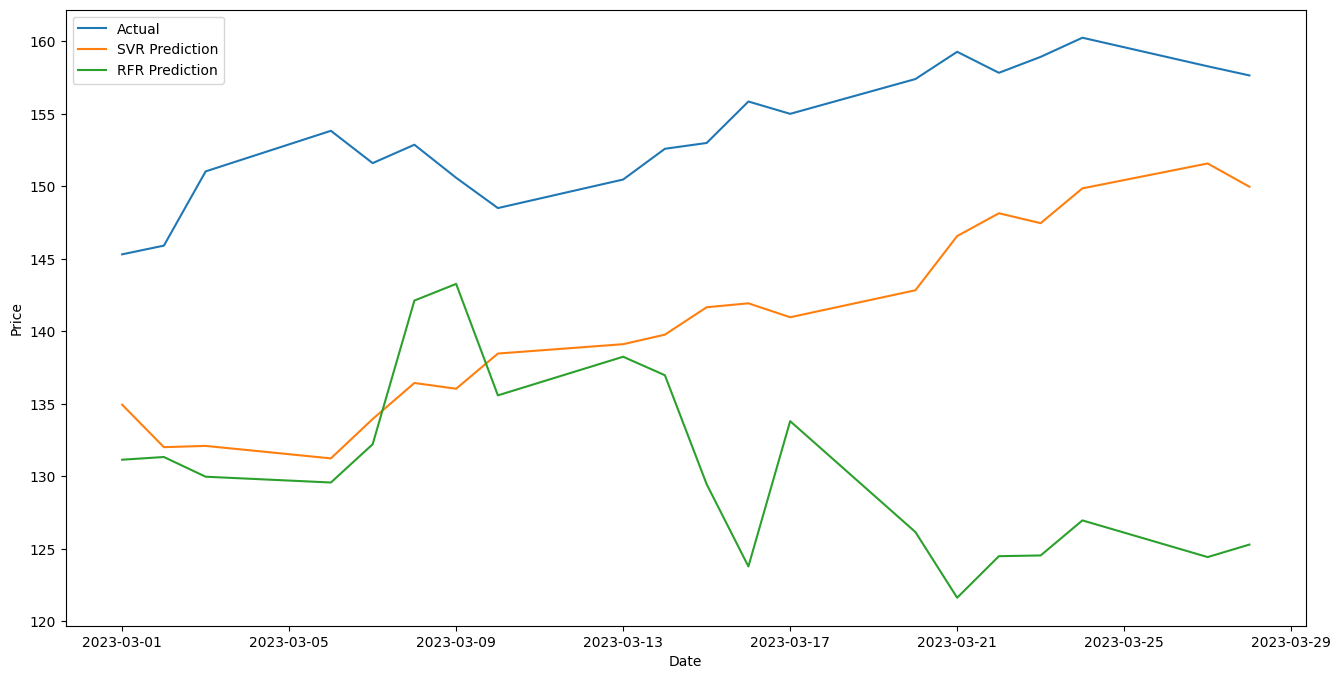

In [32]:
# Download latest 30 days historical price data from Yahoo Finance and store in a pandas DataFrame
df_actual = yf.download(
    "AAPL", start='2023-03-01', end='2023-03-29', progress=False)

number_of_days = len(df_actual)
last_n_days = df[-number_of_days:]

last_n_days_df = pd.DataFrame(
    last_n_days, columns=X.columns)

X_pred = scaler.transform(last_n_days_df)

# Make predictions for the next 30 days using the SVR & RFR model
y_svr_pred = svr_model.predict(X_pred)
y_rfr_pred = rfr_model.predict(X_pred)

# Add the predictions to the actual data in a new DataFrame
df_pred = pd.DataFrame({'SVR Prediction': y_svr_pred,
                        'RFR Prediction': y_rfr_pred}, index=df_actual.index)

df_combined = pd.concat([df_actual, df_pred], axis=1)

# Calculate evaluation metrics for SVR model
r2_svr_actual = r2_score(
    df_combined['Close'], df_combined['SVR Prediction'])
mse_svr_actual = mean_squared_error(
    df_combined['Close'], df_combined['SVR Prediction'])
mae_svr_actual = mean_absolute_error(
    df_combined['Close'], df_combined['SVR Prediction'])

# Calculate evaluation metrics for RFR model
r2_rfr_actual = r2_score(
    df_combined['Close'], df_combined['RFR Prediction'])
mse_rfr_actual = mean_squared_error(
    df_combined['Close'], df_combined['RFR Prediction'])
mae_rfr_actual = mean_absolute_error(
    df_combined['Close'], df_combined['RFR Prediction'])

# Create a table to display the evaluation metrics for both SVR and RFR models
table = [["Model", "R² (Actual)", "MSE (Actual)", "MAE (Actual)"],
         ["SVR", r2_svr_actual, mse_svr_actual, mae_svr_actual],
         ["RFR", r2_rfr_actual, mse_rfr_actual, mae_rfr_actual]]
print(tabulate(table, headers="firstrow", tablefmt="fancy_grid"))

# Plot the actual price and the predictions
plt.figure(figsize=(16, 8))
plt.plot(df_combined.index, df_combined['Close'], label='Actual')
plt.plot(df_combined.index,
         df_combined['SVR Prediction'], label='SVR Prediction')
plt.plot(df_combined.index,
         df_combined['RFR Prediction'], label='RFR Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


## Add Feature Selection using correlation coefficient


╒═════════╤══════════════╤═════════════╤═══════════════╤══════════════╤═══════════════╤══════════════╕
│ Model   │   R² (Train) │   R² (Test) │   MSE (Train) │   MSE (Test) │   MAE (Train) │   MAE (Test) │
╞═════════╪══════════════╪═════════════╪═══════════════╪══════════════╪═══════════════╪══════════════╡
│ SVR     │     0.972291 │   -0.263947 │      31.6139  │      202.765 │       3.59897 │      11.7678 │
├─────────┼──────────────┼─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ RFR     │     0.99728  │   -4.98017  │       3.10339 │      959.351 │       1.08163 │      28.0995 │
╘═════════╧══════════════╧═════════════╧═══════════════╧══════════════╧═══════════════╧══════════════╛
╒═════════╤═══════════════╤════════════════╤════════════════╕
│ Model   │   R² (Actual) │   MSE (Actual) │   MAE (Actual) │
╞═════════╪═══════════════╪════════════════╪════════════════╡
│ SVR     │      -9.19704 │        187.115 │        13.1639 │
├─────────┼───────────────┼────

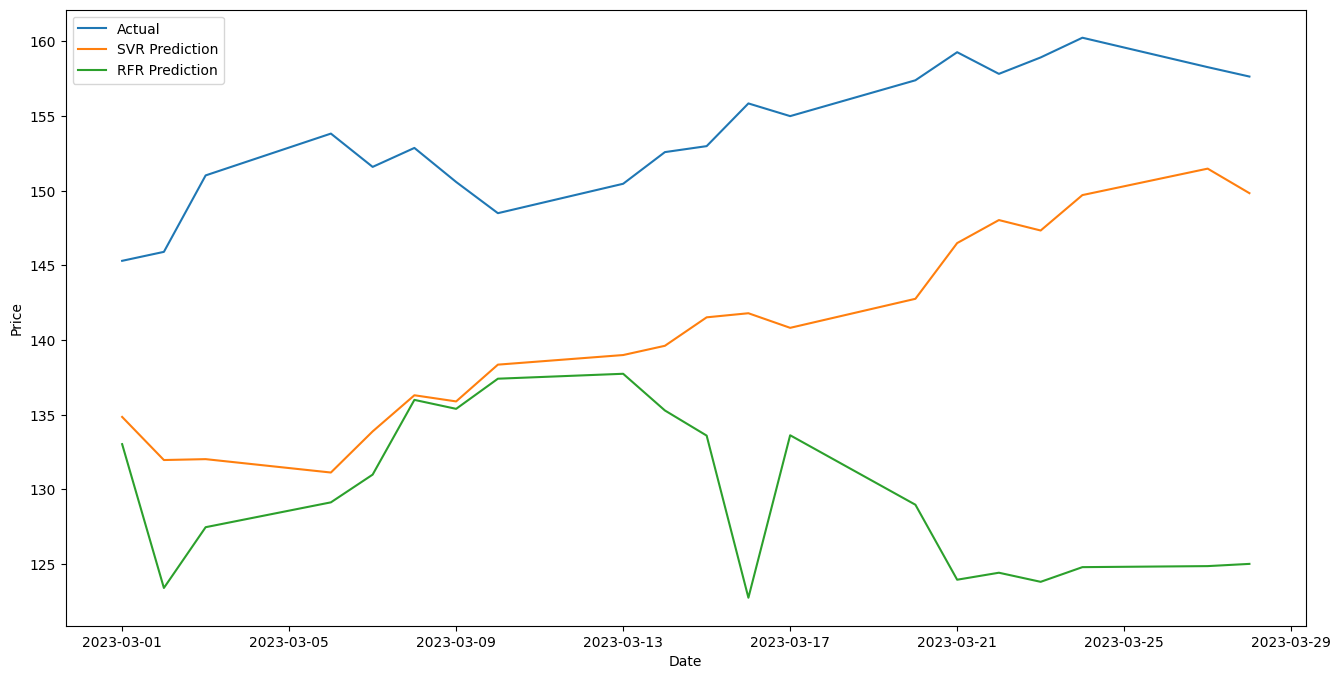

In [33]:
# Download historical price data from Yahoo Finance and store in a pandas DataFrame
df = yf.download("AAPL", start='2015-03-01', end='2023-03-01', progress=False)

# Create a new column for the dependent variable
df['PriceAfterMonth'] = df['Close'].shift(-20)

# Remove rows with missing values
df.dropna(inplace=True)

# Define the independent and dependent variables
X = df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
y = df['PriceAfterMonth']

# Perform feature selection by selecting features with a correlation coefficient of at least 0.5 with the target variable
corr = X.corrwith(y)
corr_threshold = 0.5
selected_features = corr[abs(corr) > corr_threshold].index.tolist()
X = X[selected_features]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10, shuffle=False)

# Preprocess the data by scaling it
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build SVR model
svr_model = SVR(kernel='linear', C=10, gamma='auto')
svr_model.fit(X_train, y_train)

# # Build RFR model
rfr_model = RandomForestRegressor(n_estimators=100, random_state=10)
rfr_model.fit(X_train, y_train)

evaluate_train_test(X_train, X_test)

# Download latest historical price data from Yahoo Finance and store in a pandas DataFrame
df_actual = yf.download(
    "AAPL", start='2023-03-01', end='2023-03-29', progress=False)

# Get the last 30 days of historical data
number_of_days = len(df_actual)
last_n_days = df[-number_of_days:]

last_n_days_df = pd.DataFrame(
    last_n_days, columns=X.columns)

X_pred = scaler.transform(last_n_days_df)

# Make predictions for the next 30 days using the SVR & RFR model
y_svr_pred = svr_model.predict(X_pred)
y_rfr_pred = rfr_model.predict(X_pred)

# Add the predictions to the actual data in a new DataFrame
df_pred = pd.DataFrame({'SVR Prediction': y_svr_pred,
                        'RFR Prediction': y_rfr_pred}, index=df_actual.index)

df_combined = pd.concat([df_actual, df_pred], axis=1)

# Calculate evaluation metrics for SVR model
r2_svr_actual = r2_score(df_combined['Close'], df_combined['SVR Prediction'])
mse_svr_actual = mean_squared_error(
    df_combined['Close'], df_combined['SVR Prediction'])
mae_svr_actual = mean_absolute_error(
    df_combined['Close'], df_combined['SVR Prediction'])

# Calculate evaluation metrics for RFR model
r2_rfr_actual = r2_score(df_combined['Close'], df_combined['RFR Prediction'])
mse_rfr_actual = mean_squared_error(
    df_combined['Close'], df_combined['RFR Prediction'])
mae_rfr_actual = mean_absolute_error(
    df_combined['Close'], df_combined['RFR Prediction'])

# Create a table to display the evaluation metrics for both SVR and RFR models
table = [["Model", "R² (Actual)", "MSE (Actual)", "MAE (Actual)"],
         ["SVR", r2_svr_actual, mse_svr_actual, mae_svr_actual],
         ["RFR", r2_rfr_actual, mse_rfr_actual, mae_rfr_actual]]
print(tabulate(table, headers="firstrow", tablefmt="fancy_grid"))

# Plot the actual price and the predictions
plt.figure(figsize=(16, 8))
plt.plot(df_combined.index, df_combined['Close'], label='Actual')
plt.plot(df_combined.index,
         df_combined['SVR Prediction'], label='SVR Prediction')
plt.plot(df_combined.index,
         df_combined['RFR Prediction'], label='RFR Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


It makes RFR model slightly bad, but the SVR is slightly better. 

## Add PCA

╒═════════╤══════════════╤═════════════╤═══════════════╤══════════════╤═══════════════╤══════════════╕
│ Model   │   R² (Train) │   R² (Test) │   MSE (Train) │   MSE (Test) │   MAE (Train) │   MAE (Test) │
╞═════════╪══════════════╪═════════════╪═══════════════╪══════════════╪═══════════════╪══════════════╡
│ SVR     │     0.972291 │   -0.263946 │      31.6139  │      202.765 │      3.59897  │      11.7678 │
├─────────┼──────────────┼─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ RFR     │     0.997852 │   -3.21711  │       2.45074 │      676.518 │      0.963626 │      22.2858 │
╘═════════╧══════════════╧═════════════╧═══════════════╧══════════════╧═══════════════╧══════════════╛
╒═════════╤═══════════════╤════════════════╤════════════════╕
│ Model   │   R² (Actual) │   MSE (Actual) │   MAE (Actual) │
╞═════════╪═══════════════╪════════════════╪════════════════╡
│ SVR     │      -9.19707 │        187.116 │        13.164  │
├─────────┼───────────────┼────

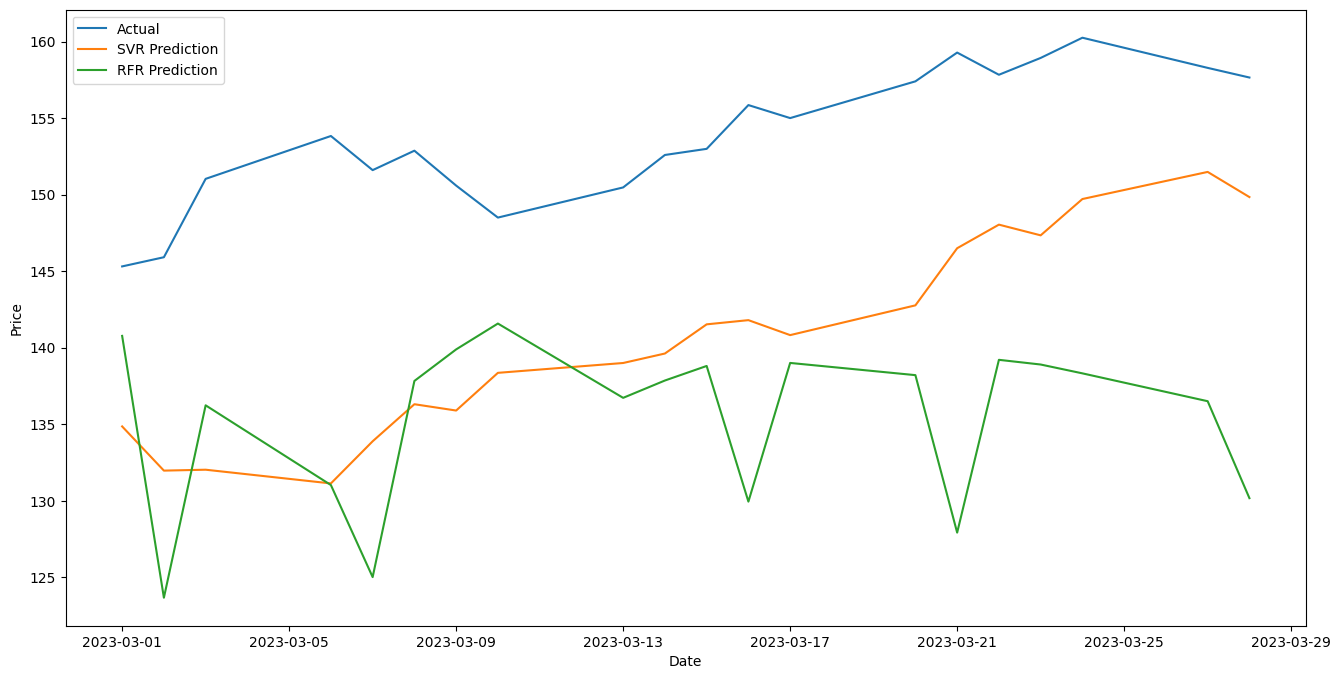

In [34]:
# Download historical price data from Yahoo Finance and store in a pandas DataFrame
df = yf.download("AAPL", start='2015-03-01', end='2023-03-01', progress=False)

# Create a new column for the dependent variable
df['PriceAfterMonth'] = df['Close'].shift(-20)

# Remove rows with missing values
df.dropna(inplace=True)

# Define the independent and dependent variables
X = df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
y = df['PriceAfterMonth']

# Perform feature selection by selecting features with a correlation coefficient of at least 0.5 with the target variable
corr = X.corrwith(y)
corr_threshold = 0.5
selected_features = corr[abs(corr) > corr_threshold].index.tolist()
X = X[selected_features]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10, shuffle=False)

# Preprocess the data by scaling it
scaler = MinMaxScaler(feature_range=(0, 1))
# scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize the PCA model:
pca_model = PCA(n_components=5)

# Fit the PCA model to the training data:
pca_model.fit(X_train)
X_train_pca = pca_model.transform(X_train)
X_test_pca = pca_model.transform(X_test)

# Build SVR model
svr_model = SVR(kernel='linear', C=10, gamma='auto')
svr_model.fit(X_train_pca, y_train)

# # Build RFR model
rfr_model = RandomForestRegressor(n_estimators=100, random_state=10)
rfr_model.fit(X_train_pca, y_train)

evaluate_train_test(X_train_pca, X_test_pca)

# Download latest historical price data from Yahoo Finance and store in a pandas DataFrame
df_actual = yf.download(
    "AAPL", start='2023-03-01', end='2023-03-29', progress=False)

# Get the last 30 days of historical data
number_of_days = len(df_actual)
last_n_days = df[-number_of_days:]

last_n_days_df = pd.DataFrame(
    last_n_days, columns=X.columns)

X_pred = scaler.transform(last_n_days_df)
X_pred_pca = pca_model.transform(X_pred)

# Make predictions for the next 30 days using the SVR & RFR model
y_svr_pred = svr_model.predict(X_pred_pca)
y_rfr_pred = rfr_model.predict(X_pred_pca)

# Add the predictions to the actual data in a new DataFrame
df_pred = pd.DataFrame({'SVR Prediction': y_svr_pred,
                        'RFR Prediction': y_rfr_pred}, index=df_actual.index)

df_combined = pd.concat([df_actual, df_pred], axis=1)

# Calculate evaluation metrics for SVR model
r2_svr_actual = r2_score(df_combined['Close'], df_combined['SVR Prediction'])
mse_svr_actual = mean_squared_error(
    df_combined['Close'], df_combined['SVR Prediction'])
mae_svr_actual = mean_absolute_error(
    df_combined['Close'], df_combined['SVR Prediction'])

# Calculate evaluation metrics for RFR model
r2_rfr_actual = r2_score(df_combined['Close'], df_combined['RFR Prediction'])
mse_rfr_actual = mean_squared_error(
    df_combined['Close'], df_combined['RFR Prediction'])
mae_rfr_actual = mean_absolute_error(
    df_combined['Close'], df_combined['RFR Prediction'])

# Create a table to display the evaluation metrics for both SVR and RFR models
table = [["Model", "R² (Actual)", "MSE (Actual)", "MAE (Actual)"],
         ["SVR", r2_svr_actual, mse_svr_actual, mae_svr_actual],
         ["RFR", r2_rfr_actual, mse_rfr_actual, mae_rfr_actual]]
print(tabulate(table, headers="firstrow", tablefmt="fancy_grid"))

# Plot the actual price and the predictions
plt.figure(figsize=(16, 8))
plt.plot(df_combined.index, df_combined['Close'], label='Actual')
plt.plot(df_combined.index,
         df_combined['SVR Prediction'], label='SVR Prediction')
plt.plot(df_combined.index,
         df_combined['RFR Prediction'], label='RFR Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


After using PCA, it makes RFR & SVR model become worse.

## Add PolynomialFeatures without Constant (bias)

╒═════════╤══════════════╤═════════════╤═══════════════╤══════════════╤═══════════════╤══════════════╕
│ Model   │   R² (Train) │   R² (Test) │   MSE (Train) │   MSE (Test) │   MAE (Train) │   MAE (Test) │
╞═════════╪══════════════╪═════════════╪═══════════════╪══════════════╪═══════════════╪══════════════╡
│ SVR     │     0.976522 │    -6.40164 │      26.7857  │     1187.39  │       3.30443 │      29.3815 │
├─────────┼──────────────┼─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ RFR     │     0.997273 │    -4.99892 │       3.11115 │      962.359 │       1.08941 │      28.1728 │
╘═════════╧══════════════╧═════════════╧═══════════════╧══════════════╧═══════════════╧══════════════╛
╒═════════╤═══════════════╤════════════════╤════════════════╕
│ Model   │   R² (Actual) │   MSE (Actual) │   MAE (Actual) │
╞═════════╪═══════════════╪════════════════╪════════════════╡
│ SVR     │      -30.3392 │        575.073 │        23.7091 │
├─────────┼───────────────┼────

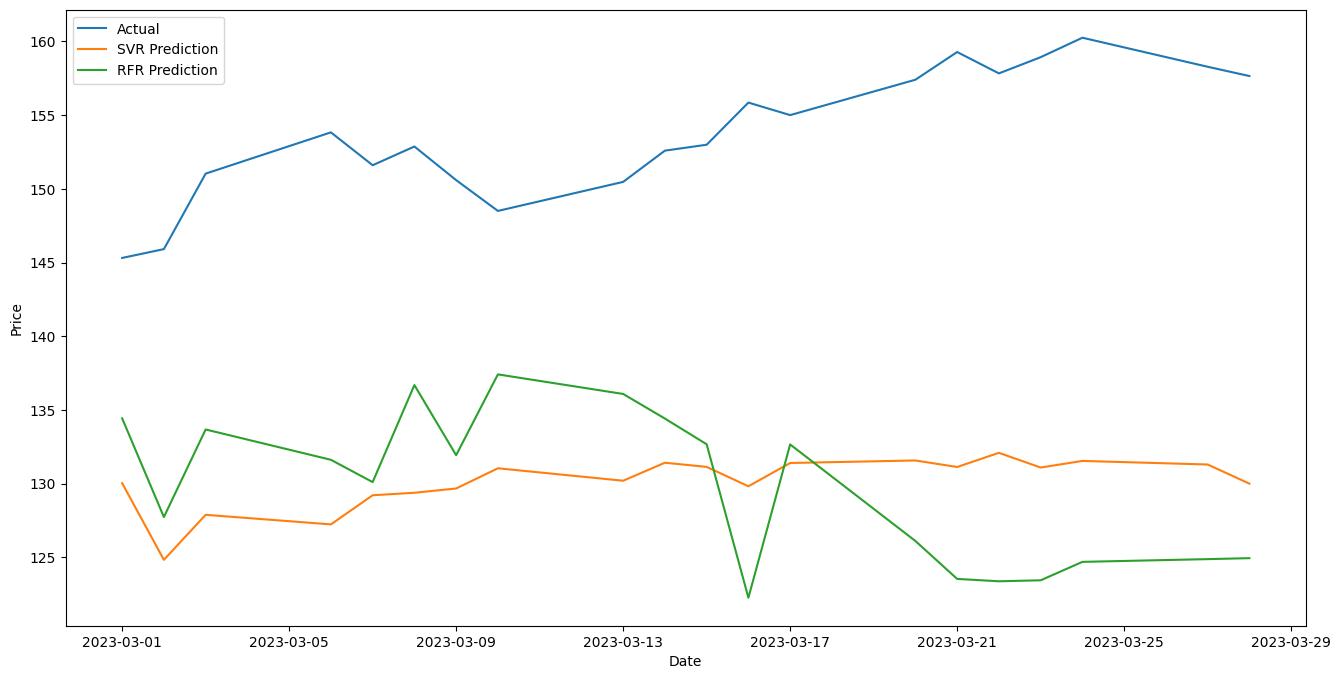

In [35]:
# Download historical price data from Yahoo Finance and store in a pandas DataFrame
df = yf.download("AAPL", start='2015-03-01', end='2023-03-01', progress=False)

# Create a new column for the dependent variable
df['PriceAfterMonth'] = df['Close'].shift(-20)

# Remove rows with missing values
df.dropna(inplace=True)

# Define the independent and dependent variables
X = df.drop('PriceAfterMonth', axis=1)
y = df['PriceAfterMonth']

# Perform feature selection by selecting features with a correlation coefficient of at least 0.5 with the target variable
corr = X.corrwith(y)
corr_threshold = 0.5
selected_features = corr[abs(corr) > corr_threshold].index.tolist()
X = X[selected_features]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10, shuffle=False)

# Preprocess the data by scaling it
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply PolynomialFeatures to the data
poly = PolynomialFeatures(degree=3, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Build SVR model
svr_model = SVR(kernel='linear', C=10, gamma='auto')
svr_model.fit(X_train_poly, y_train)

# # Build RFR model
rfr_model = RandomForestRegressor(
    n_estimators=50, random_state=10)
rfr_model.fit(X_train_poly, y_train)

evaluate_train_test(X_train_poly, X_test_poly)

# Download latest historical price data from Yahoo Finance and store in a pandas DataFrame
df_actual = yf.download(
    "AAPL", start='2023-03-01', end='2023-03-29', progress=False)

# Get the last 30 days of historical data
number_of_days = len(df_actual)
last_n_days = df[-number_of_days:]

last_n_days_df = pd.DataFrame(
    last_n_days, columns=X.columns)

X_pred = scaler.transform(last_n_days_df)
X_pred_poly = poly.transform(X_pred)

# Make predictions for the next 30 days using the SVR & RFR model
y_svr_pred = svr_model.predict(X_pred_poly)
y_rfr_pred = rfr_model.predict(X_pred_poly)

# Add the predictions to the actual data in a new DataFrame
df_pred = pd.DataFrame({'SVR Prediction': y_svr_pred,
                        'RFR Prediction': y_rfr_pred}, index=df_actual.index)

df_combined = pd.concat([df_actual, df_pred], axis=1)

# Calculate evaluation metrics for SVR model
r2_svr_actual = r2_score(
    df_combined['Close'], df_combined['SVR Prediction'])
mse_svr_actual = mean_squared_error(
    df_combined['Close'], df_combined['SVR Prediction'])
mae_svr_actual = mean_absolute_error(
    df_combined['Close'], df_combined['SVR Prediction'])

# Calculate evaluation metrics for RFR model
r2_rfr_actual = r2_score(
    df_combined['Close'], df_combined['RFR Prediction'])
mse_rfr_actual = mean_squared_error(
    df_combined['Close'], df_combined['RFR Prediction'])
mae_rfr_actual = mean_absolute_error(
    df_combined['Close'], df_combined['RFR Prediction'])

# Create a table to display the evaluation metrics for both SVR and RFR models
table = [["Model", "R² (Actual)", "MSE (Actual)", "MAE (Actual)"],
         ["SVR", r2_svr_actual, mse_svr_actual, mae_svr_actual],
         ["RFR", r2_rfr_actual, mse_rfr_actual, mae_rfr_actual]]
print(tabulate(table, headers="firstrow", tablefmt="fancy_grid"))

# Plot the actual price and the predictions
plt.figure(figsize=(16, 8))
plt.plot(df_combined.index, df_combined['Close'], label='Actual')
plt.plot(df_combined.index,
         df_combined['SVR Prediction'], label='SVR Prediction')
plt.plot(df_combined.index,
         df_combined['RFR Prediction'], label='RFR Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## Add PolynomialFeatures with Constant (bias)

╒═════════╤══════════════╤═════════════╤═══════════════╤══════════════╤═══════════════╤══════════════╕
│ Model   │   R² (Train) │   R² (Test) │   MSE (Train) │   MSE (Test) │   MAE (Train) │   MAE (Test) │
╞═════════╪══════════════╪═════════════╪═══════════════╪══════════════╪═══════════════╪══════════════╡
│ SVR     │     0.976522 │    -6.40169 │      26.7857  │      1187.39 │       3.30442 │      29.3815 │
├─────────┼──────────────┼─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ RFR     │     0.997234 │    -4.97118 │       3.15531 │       957.91 │       1.08901 │      28.0948 │
╘═════════╧══════════════╧═════════════╧═══════════════╧══════════════╧═══════════════╧══════════════╛
╒═════════╤═══════════════╤════════════════╤════════════════╕
│ Model   │   R² (Actual) │   MSE (Actual) │   MAE (Actual) │
╞═════════╪═══════════════╪════════════════╪════════════════╡
│ SVR     │      -30.339  │        575.068 │        23.709  │
├─────────┼───────────────┼────

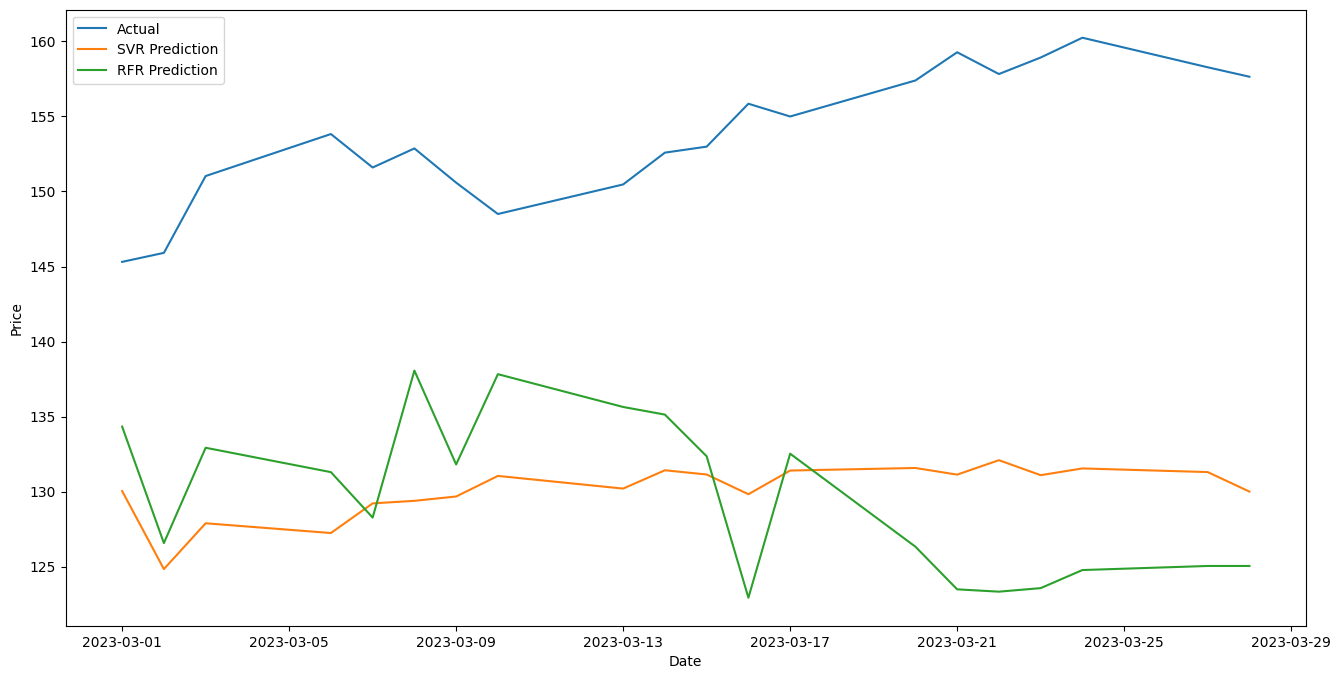

In [36]:
# Download historical price data from Yahoo Finance and store in a pandas DataFrame
df = yf.download("AAPL", start='2015-03-01', end='2023-03-01', progress=False)

# Create a new column for the dependent variable
df['PriceAfterMonth'] = df['Close'].shift(-20)

# Remove rows with missing values
df.dropna(inplace=True)

# Define the independent and dependent variables
X = df.drop('PriceAfterMonth', axis=1)
y = df['PriceAfterMonth']

# Perform feature selection by selecting features with a correlation coefficient of at least 0.5 with the target variable
corr = X.corrwith(y)
corr_threshold = 0.5
selected_features = corr[abs(corr) > corr_threshold].index.tolist()
X = X[selected_features]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10, shuffle=False)

# Preprocess the data by scaling it
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply PolynomialFeatures to the data
poly = PolynomialFeatures(degree=3, include_bias=True)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Build SVR model
svr_model = SVR(kernel='linear', C=10, gamma='auto')
svr_model.fit(X_train_poly, y_train)

# # Build RFR model
rfr_model = RandomForestRegressor(
    n_estimators=50, random_state=10)
rfr_model.fit(X_train_poly, y_train)

evaluate_train_test(X_train_poly, X_test_poly)

# Download latest historical price data from Yahoo Finance and store in a pandas DataFrame
df_actual = yf.download(
    "AAPL", start='2023-03-01', end='2023-03-29', progress=False)

# Get the last 30 days of historical data
number_of_days = len(df_actual)
last_n_days = df[-number_of_days:]

last_n_days_df = pd.DataFrame(
    last_n_days, columns=X.columns)

X_pred = scaler.transform(last_n_days_df)
X_pred_poly = poly.transform(X_pred)

# Make predictions for the next 30 days using the SVR & RFR model
y_svr_pred = svr_model.predict(X_pred_poly)
y_rfr_pred = rfr_model.predict(X_pred_poly)

# Add the predictions to the actual data in a new DataFrame
df_pred = pd.DataFrame({'SVR Prediction': y_svr_pred,
                        'RFR Prediction': y_rfr_pred}, index=df_actual.index)

df_combined = pd.concat([df_actual, df_pred], axis=1)

# Calculate evaluation metrics for SVR model
r2_svr_actual = r2_score(
    df_combined['Close'], df_combined['SVR Prediction'])
mse_svr_actual = mean_squared_error(
    df_combined['Close'], df_combined['SVR Prediction'])
mae_svr_actual = mean_absolute_error(
    df_combined['Close'], df_combined['SVR Prediction'])

# Calculate evaluation metrics for RFR model
r2_rfr_actual = r2_score(
    df_combined['Close'], df_combined['RFR Prediction'])
mse_rfr_actual = mean_squared_error(
    df_combined['Close'], df_combined['RFR Prediction'])
mae_rfr_actual = mean_absolute_error(
    df_combined['Close'], df_combined['RFR Prediction'])

# Create a table to display the evaluation metrics for both SVR and RFR models
table = [["Model", "R² (Actual)", "MSE (Actual)", "MAE (Actual)"],
         ["SVR", r2_svr_actual, mse_svr_actual, mae_svr_actual],
         ["RFR", r2_rfr_actual, mse_rfr_actual, mae_rfr_actual]]
print(tabulate(table, headers="firstrow", tablefmt="fancy_grid"))

# Plot the actual price and the predictions
plt.figure(figsize=(16, 8))
plt.plot(df_combined.index, df_combined['Close'], label='Actual')
plt.plot(df_combined.index,
         df_combined['SVR Prediction'], label='SVR Prediction')
plt.plot(df_combined.index,
         df_combined['RFR Prediction'], label='RFR Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


RFR models has been doing well right now. However, SVR still need to perform extra techinque.

## Add Features by using Technical Indicators 


In [37]:
# Download historical price data from Yahoo Finance and store in a pandas DataFrame
df = yf.download("AAPL", start='2015-03-01', end='2023-03-01', progress=False)

# Add technical indicators
# Simple Moving Average (SMA)
df['SMA_10'] = ta.trend.SMAIndicator(df['Close'], window=10).sma_indicator()

# Exponential Moving Average (EMA)
df['EMA_10'] = ta.trend.EMAIndicator(df['Close'], window=10).ema_indicator()

# Relative Strength Index (RSI)
df['RSI'] = ta.momentum.RSIIndicator(df['Close'], window=10).rsi()

# Average True Range (ATR)
df['ATR'] = ta.volatility.AverageTrueRange(
    df['High'], df['Low'], df['Close'], window=14)

# Moving Average Convergence Divergence (MACD)
macd = ta.trend.MACD(df['Close'], window_slow=26,
                     window_fast=12, window_sign=9)
df['MACD'] = macd.macd()
df['MACD_Signal'] = macd.macd_signal()

# Create a new column for the dependent variable
df['PriceAfterMonth'] = df['Close'].shift(-20)

# Remove rows with missing values
df.dropna(inplace=True)

# Define the independent and dependent variables
X = df.drop('PriceAfterMonth', axis=1)
y = df['PriceAfterMonth']

# Perform feature selection by selecting features with a correlation coefficient of at least 0.5 with the target variable
corr = X.corrwith(y)
corr_threshold = 0.5
selected_features = corr[abs(corr) > corr_threshold].index.tolist()
X = X[selected_features]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10, shuffle=False)

# Preprocess the data by scaling it
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply PolynomialFeatures to the data
poly = PolynomialFeatures(degree=3, include_bias=True)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Build SVR model
svr_model = SVR(kernel='linear', C=10)
svr_model.fit(X_train_poly, y_train)

evaluate_train_test_svr(X_train_poly, X_test_poly)

╒═════════╤══════════════╤═════════════╤═══════════════╤══════════════╤═══════════════╤══════════════╕
│ Model   │   R² (Train) │   R² (Test) │   MSE (Train) │   MSE (Test) │   MAE (Train) │   MAE (Test) │
╞═════════╪══════════════╪═════════════╪═══════════════╪══════════════╪═══════════════╪══════════════╡
│ SVR     │     0.976434 │    -6.46164 │       27.7688 │      1209.47 │       3.39346 │      29.6512 │
╘═════════╧══════════════╧═════════════╧═══════════════╧══════════════╧═══════════════╧══════════════╛


╒═════════╤═══════════════╤════════════════╤════════════════╕
│ Model   │   R² (Actual) │   MSE (Actual) │   MAE (Actual) │
╞═════════╪═══════════════╪════════════════╪════════════════╡
│ SVR     │      -26.8723 │        511.455 │        22.3413 │
├─────────┼───────────────┼────────────────┼────────────────┤
│ RFR     │      -35.0155 │        660.883 │        24.2497 │
╘═════════╧═══════════════╧════════════════╧════════════════╛


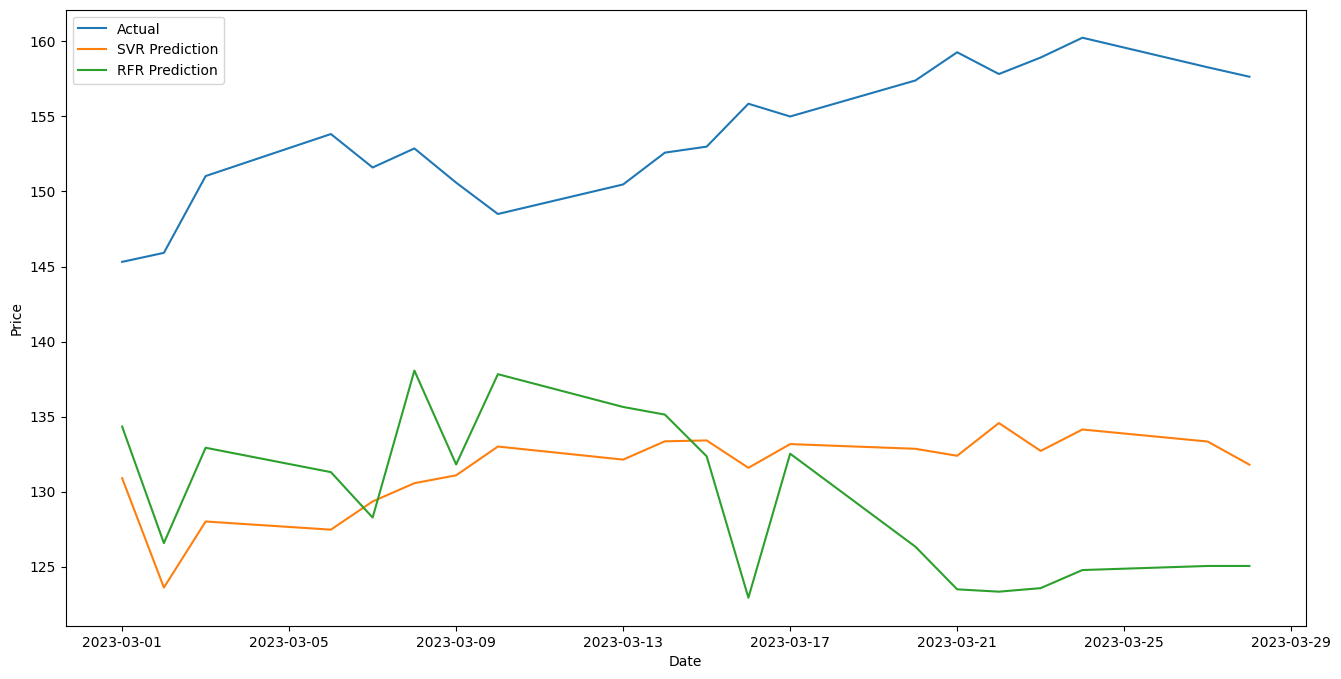

In [38]:
# Download latest historical price data from Yahoo Finance and store in a pandas DataFrame
df_actual = yf.download(
    "AAPL", start='2023-03-01', end='2023-03-29', progress=False)

# Get the last 30 days of historical data
number_of_days = len(df_actual)
last_n_days = df[-number_of_days:]

last_n_days_df = pd.DataFrame(
    last_n_days, columns=X.columns)

X_pred = scaler.transform(last_n_days_df)
X_pred_poly = poly.transform(X_pred)

# Make predictions for the next 30 days using the SVR & RFR model
y_svr_pred = svr_model.predict(X_pred_poly)

# Add the predictions to the actual data in a new DataFrame
df_pred = pd.DataFrame({'SVR Prediction': y_svr_pred,
                        'RFR Prediction': y_rfr_pred}, index=df_actual.index)

df_combined = pd.concat([df_actual, df_pred], axis=1)

# Calculate evaluation metrics for SVR model
r2_svr_actual = r2_score(df_combined['Close'], df_combined['SVR Prediction'])
mse_svr_actual = mean_squared_error(
    df_combined['Close'], df_combined['SVR Prediction'])
mae_svr_actual = mean_absolute_error(
    df_combined['Close'], df_combined['SVR Prediction'])

# Create a table to display the evaluation metrics for both SVR and RFR models
table = [["Model", "R² (Actual)", "MSE (Actual)", "MAE (Actual)"],
         ["SVR", r2_svr_actual, mse_svr_actual, mae_svr_actual],
         ["RFR", r2_rfr_actual, mse_rfr_actual, mae_rfr_actual]]
print(tabulate(table, headers="firstrow", tablefmt="fancy_grid"))

# Plot the actual price and the predictions
plt.figure(figsize=(16, 8))
plt.plot(df_combined.index, df_combined['Close'], label='Actual')
plt.plot(df_combined.index,
         df_combined['SVR Prediction'], label='SVR Prediction')
plt.plot(df_combined.index,
         df_combined['RFR Prediction'], label='RFR Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


# Apply GridSearchCV

RFR Model

In [39]:
result_table = []

# Define the parameter grid to search over
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Download historical price data from Yahoo Finance and store in a pandas DataFrame
df = yf.download("AAPL", start='2015-03-01', end='2023-03-01', progress=False)

# Create a new column for the dependent variable
df['PriceAfterMonth'] = df['Close'].shift(-20)

# Remove rows with missing values
df.dropna(inplace=True)

# Define the independent and dependent variables
X = df.drop('PriceAfterMonth', axis=1)
y = df['PriceAfterMonth']

# Perform feature selection by selecting features with a correlation coefficient of at least 0.5 with the target variable
corr = X.corrwith(y)
corr_threshold = 0.5
selected_features = corr[abs(corr) > corr_threshold].index.tolist()
X = X[selected_features]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10, shuffle=False)

# Preprocess the data by scaling it
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply PolynomialFeatures to the data
poly = PolynomialFeatures(degree=3, include_bias=True)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Create a GridSearchCV object with the parameter grid and the Random Forest Regressor model
grid_search_rfr = GridSearchCV(
    estimator=RandomForestRegressor(random_state=10),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='neg_mean_squared_error'
)

# Fit the GridSearchCV object to the training data
grid_search_rfr.fit(X_train_poly, y_train)

# Get the best model
rfr_model = grid_search_rfr.best_estimator_

# Calculate evaluation metrics for RFR model
y_rfr_pred_train = rfr_model.predict(X_train_poly)
r2_rfr_train = r2_score(y_train, y_rfr_pred_train)
mse_rfr_train = mean_squared_error(y_train, y_rfr_pred_train)
mae_rfr_train = mean_absolute_error(y_train, y_rfr_pred_train)

y_rfr_pred_test = rfr_model.predict(X_test_poly)
r2_rfr_test = r2_score(y_test, y_rfr_pred_test)
mse_rfr_test = mean_squared_error(y_test, y_rfr_pred_test)
mae_rfr_test = mean_absolute_error(y_test, y_rfr_pred_test)

rfr_result = ["RFR", r2_rfr_train, r2_rfr_test, mse_rfr_train,
            mse_rfr_test, mae_rfr_train, mae_rfr_test]
result_table.append(rfr_result)

# Download latest historical price data from Yahoo Finance and store in a pandas DataFrame
df_actual = yf.download(
    "AAPL", start='2023-03-01', end='2023-03-29', progress=False)

# Get the last 30 days of historical data
number_of_days = len(df_actual)
last_n_days = df[-number_of_days:]

last_n_days_df = pd.DataFrame(
    last_n_days, columns=X.columns)

X_pred = scaler.transform(last_n_days_df)
X_pred_poly = poly.transform(X_pred)

# Make predictions for the next 30 days using the SVR & RFR model
y_rfr_pred = rfr_model.predict(X_pred_poly)

SVR model

In [ ]:
# Define the parameter grid
param_grid = {
    'kernel': ['linear', 'poly', 'rbf'],
    'C': [1, 10, 100, 1000],
    'gamma': ['auto', 'scale'],
}

# Download historical price data from Yahoo Finance and store in a pandas DataFrame
df = yf.download("AAPL", start='2015-03-01', end='2023-03-01', progress=False)

# Add technical indicators
# Simple Moving Average (SMA)
df['SMA_10'] = ta.trend.SMAIndicator(df['Close'], window=10).sma_indicator()

# Exponential Moving Average (EMA)
df['EMA_10'] = ta.trend.EMAIndicator(df['Close'], window=10).ema_indicator()

# Relative Strength Index (RSI)
df['RSI'] = ta.momentum.RSIIndicator(df['Close'], window=10).rsi()

# Average True Range (ATR)
df['ATR'] = ta.volatility.AverageTrueRange(
    df['High'], df['Low'], df['Close'], window=14)

# Moving Average Convergence Divergence (MACD)
macd = ta.trend.MACD(df['Close'], window_slow=26,
                     window_fast=12, window_sign=9)
df['MACD'] = macd.macd()
df['MACD_Signal'] = macd.macd_signal()

# Create a new column for the dependent variable
df['PriceAfterMonth'] = df['Close'].shift(-20)

# Remove rows with missing values
df.dropna(inplace=True)

# Define the independent and dependent variables
X = df.drop('PriceAfterMonth', axis=1)
y = df['PriceAfterMonth']

# Perform feature selection by selecting features with a correlation coefficient of at least 0.5 with the target variable
corr = X.corrwith(y)
corr_threshold = 0.5
selected_features = corr[abs(corr) > corr_threshold].index.tolist()
X = X[selected_features]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10, shuffle=False)

# Preprocess the data by scaling it
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply PolynomialFeatures to the data
poly = PolynomialFeatures(degree=3, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Create a GridSearchCV object with the parameter grid and the Random Forest Regressor model
grid_search_svr = GridSearchCV(
    estimator=SVR(),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='neg_mean_squared_error'
)

# Fit the GridSearchCV object to the training data
grid_search_svr.fit(X_train_poly, y_train)

# Get the best model
svr_model = grid_search_svr.best_estimator_

# Calculate evaluation metrics for SVR model
y_svr_pred_train = svr_model.predict(X_train_poly)
r2_svr_train = r2_score(y_train, y_svr_pred_train)
mse_svr_train = mean_squared_error(y_train, y_svr_pred_train)
mae_svr_train = mean_absolute_error(y_train, y_svr_pred_train)

y_svr_pred_test = svr_model.predict(X_test_poly)
r2_svr_test = r2_score(y_test, y_svr_pred_test)
mse_svr_test = mean_squared_error(y_test, y_svr_pred_test)
mae_svr_test = mean_absolute_error(y_test, y_svr_pred_test)

svr_result = ["SVR", r2_svr_train, r2_svr_test, mse_svr_train,
            mse_svr_test, mae_svr_train, mae_svr_test]

result_table.append(svr_result)

# Download latest historical price data from Yahoo Finance and store in a pandas DataFrame
df_actual = yf.download(
    "AAPL", start='2023-03-01', end='2023-03-29', progress=False)

# Get the last 30 days of historical data
number_of_days = len(df_actual)
last_n_days = df[-number_of_days:]

last_n_days_df = pd.DataFrame(
    last_n_days, columns=X.columns)

X_pred = scaler.transform(last_n_days_df)
X_pred_poly = poly.transform(X_pred)

# Make predictions for the next 30 days using the SVR & RFR model
y_svr_pred = svr_model.predict(X_pred_poly)

Evaluate SVR & RFR Performance Based on Actual Data

╒═════════╤═══════════════╤════════════════╤════════════════╕
│ Model   │   R² (Actual) │   MSE (Actual) │   MAE (Actual) │
╞═════════╪═══════════════╪════════════════╪════════════════╡
│ SVR     │      -20.4901 │        394.342 │        19.6866 │
├─────────┼───────────────┼────────────────┼────────────────┤
│ RFR     │      -35.5311 │        670.343 │        24.4851 │
╘═════════╧═══════════════╧════════════════╧════════════════╛


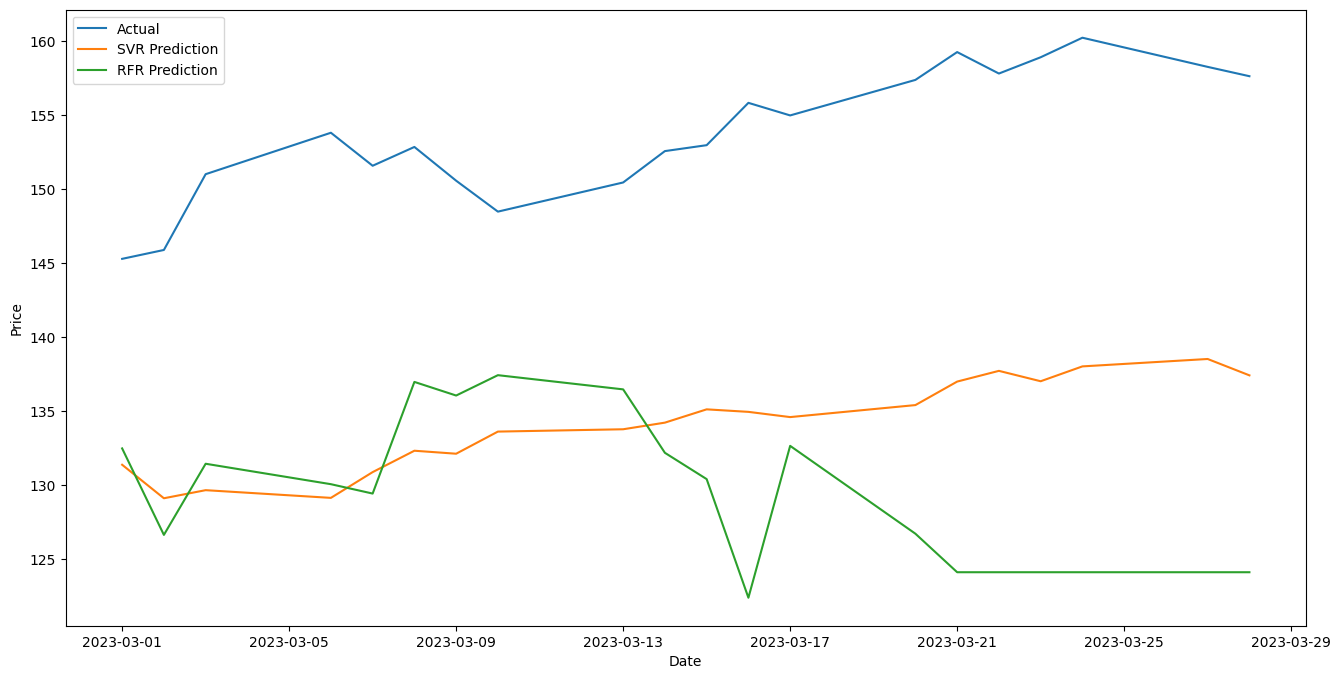

In [ ]:
# Add the predictions to the actual data in a new DataFrame
df_pred = pd.DataFrame({'SVR Prediction': y_svr_pred,
                        'RFR Prediction': y_rfr_pred}, index=df_actual.index)

df_combined = pd.concat([df_actual, df_pred], axis=1)

# Calculate evaluation metrics for SVR model
r2_svr_actual = r2_score(
    df_combined['Close'], df_combined['SVR Prediction'])
mse_svr_actual = mean_squared_error(
    df_combined['Close'], df_combined['SVR Prediction'])
mae_svr_actual = mean_absolute_error(
    df_combined['Close'], df_combined['SVR Prediction'])

# Calculate evaluation metrics for RFR model
r2_rfr_actual = r2_score(
    df_combined['Close'], df_combined['RFR Prediction'])
mse_rfr_actual = mean_squared_error(
    df_combined['Close'], df_combined['RFR Prediction'])
mae_rfr_actual = mean_absolute_error(
    df_combined['Close'], df_combined['RFR Prediction'])

# Create a table to display the evaluation metrics for both SVR and RFR models
table = [["Model", "R² (Actual)", "MSE (Actual)", "MAE (Actual)"],
         ["SVR", r2_svr_actual, mse_svr_actual, mae_svr_actual],
         ["RFR", r2_rfr_actual, mse_rfr_actual, mae_rfr_actual]]
print(tabulate(table, headers="firstrow", tablefmt="fancy_grid"))

# Plot the actual price and the predictions
plt.figure(figsize=(16, 8))
plt.plot(df_combined.index, df_combined['Close'], label='Actual')
plt.plot(df_combined.index,
         df_combined['SVR Prediction'], label='SVR Prediction')
plt.plot(df_combined.index,
         df_combined['RFR Prediction'], label='RFR Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

Ensemble Model (RFR + SVR)

In [ ]:
from sklearn.ensemble import VotingRegressor

# Use VotingRegressor to combine RFR and SVR models
ensemble_model = VotingRegressor(estimators=[('rfr', rfr_model), ('svr', svr_model)])
ensemble_model.fit(X_train_poly, y_train)

y_ensemble_pred_train = ensemble_model.predict(X_train_poly)
r2_ensemble_train = r2_score(y_train, y_ensemble_pred_train)
mse_ensemble_train = mean_squared_error(y_train, y_ensemble_pred_train)
mae_ensemble_train = mean_absolute_error(y_train, y_ensemble_pred_train)

y_ensemble_pred_test = ensemble_model.predict(X_test_poly)
r2_ensemble_test = r2_score(y_test, y_ensemble_pred_test)
mse_ensemble_test = mean_squared_error(y_test, y_ensemble_pred_test)
mae_ensemble_test = mean_absolute_error(y_test, y_ensemble_pred_test)

ensemble_result = ["Ensemble", r2_ensemble_train, r2_ensemble_test, mse_ensemble_train,
            mse_ensemble_test, mae_ensemble_train, mae_ensemble_test]

result_table.append(ensemble_result)

y_ensemble_pred = ensemble_model.predict(X_pred_poly)

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


In [ ]:
# Calculate evaluation metrics for train & test set from each model
print(tabulate(result_table, headers=["Model", "R² (Train)", "R² (Test)",
                                    "MSE (Train)", "MSE (Test)", "MAE (Train)", "MAE (Test)"], tablefmt="fancy_grid"))

╒══════════╤══════════════╤═════════════╤═══════════════╤══════════════╤═══════════════╤══════════════╕
│ Model    │   R² (Train) │   R² (Test) │   MSE (Train) │   MSE (Test) │   MAE (Train) │   MAE (Test) │
╞══════════╪══════════════╪═════════════╪═══════════════╪══════════════╪═══════════════╪══════════════╡
│ RFR      │     0.993522 │    -5.21689 │       7.39031 │      997.327 │       1.65813 │      28.7324 │
├──────────┼──────────────┼─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ SVR      │     0.975853 │    -2.2287  │      28.4529  │      523.345 │       3.52765 │      19.0749 │
├──────────┼──────────────┼─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ Ensemble │     0.98896  │    -1.96464 │      13.0085  │      480.542 │       2.35225 │      18.3945 │
╘══════════╧══════════════╧═════════════╧═══════════════╧══════════════╧═══════════════╧══════════════╛


╒══════════╤═══════════════╤════════════════╤════════════════╕
│ Model    │   R² (Actual) │   MSE (Actual) │   MAE (Actual) │
╞══════════╪═══════════════╪════════════════╪════════════════╡
│ SVR      │      -20.4901 │        394.342 │        19.6866 │
├──────────┼───────────────┼────────────────┼────────────────┤
│ RFR      │      -35.5311 │        670.343 │        24.4851 │
├──────────┼───────────────┼────────────────┼────────────────┤
│ Ensemble │      -19.439  │        375.055 │        19.0932 │
╘══════════╧═══════════════╧════════════════╧════════════════╛


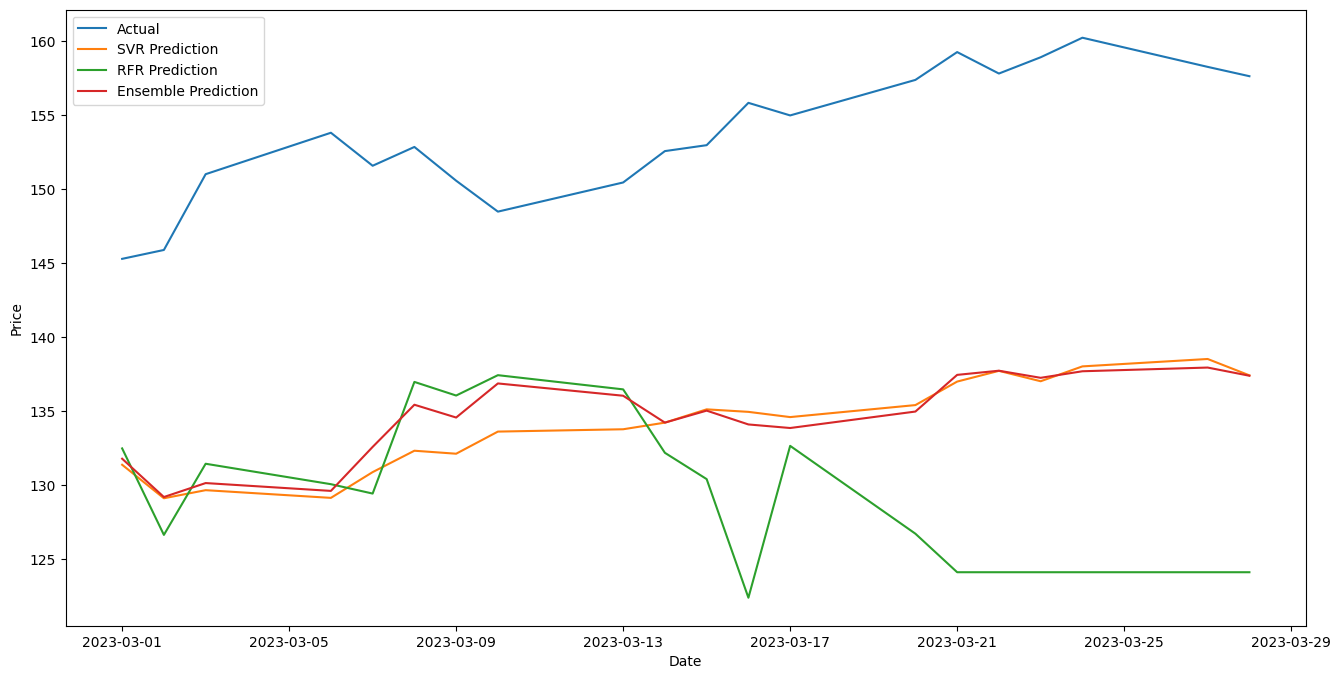

In [ ]:
# Add the predictions to the actual data in a new DataFrame
df_pred = pd.DataFrame({'SVR Prediction': y_svr_pred,
                        'RFR Prediction': y_rfr_pred,
                        'Ensemble Predcition': y_ensemble_pred}, index=df_actual.index)

df_combined = pd.concat([df_actual, df_pred], axis=1)

# Calculate evaluation metrics for ensemble model
r2_svr_actual = r2_score(
    df_combined['Close'], df_combined['SVR Prediction'])
mse_svr_actual = mean_squared_error(
    df_combined['Close'], df_combined['SVR Prediction'])
mae_svr_actual = mean_absolute_error(
    df_combined['Close'], df_combined['SVR Prediction'])

# Calculate evaluation metrics for RFR model
r2_rfr_actual = r2_score(
    df_combined['Close'], df_combined['RFR Prediction'])
mse_rfr_actual = mean_squared_error(
    df_combined['Close'], df_combined['RFR Prediction'])
mae_rfr_actual = mean_absolute_error(
    df_combined['Close'], df_combined['RFR Prediction'])

# Calculate evaluation metrics for RFR model
r2_ensemble_actual = r2_score(
    df_combined['Close'], df_combined['Ensemble Predcition'])
mse_ensemble_actual = mean_squared_error(
    df_combined['Close'], df_combined['Ensemble Predcition'])
mae_ensemble_actual = mean_absolute_error(
    df_combined['Close'], df_combined['Ensemble Predcition'])

# Create a table to display the evaluation metrics for both SVR and RFR models
table = [["Model", "R² (Actual)", "MSE (Actual)", "MAE (Actual)"],
         ["SVR", r2_svr_actual, mse_svr_actual, mae_svr_actual],
         ["RFR", r2_rfr_actual, mse_rfr_actual, mae_rfr_actual],
         ["Ensemble", r2_ensemble_actual, mse_ensemble_actual, mae_ensemble_actual]]
print(tabulate(table, headers="firstrow", tablefmt="fancy_grid"))

# Plot the actual price and the predictions
plt.figure(figsize=(16, 8))
plt.plot(df_combined.index, df_combined['Close'], label='Actual')
plt.plot(df_combined.index,
         df_combined['SVR Prediction'], label='SVR Prediction')
plt.plot(df_combined.index,
         df_combined['RFR Prediction'], label='RFR Prediction')
plt.plot(df_combined.index,
         df_combined['Ensemble Predcition'], label='Ensemble Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Interepret Library

## SHAP

In [ ]:


# feature_names = poly.get_feature_names_out(X.columns)

# def ensemble_predict(X):
#     preds = ensemble_model.predict(X)
#     return preds

# explainer = shap.Explainer(ensemble_predict, X_train_poly)
# shap_values = explainer(X_test_poly)

# # Plot SHAP summary plot
# shap.summary_plot(shap_values, X_test_poly, feature_names=feature_names)

Permutation explainer:  23%|██▎       | 89/393 [06:02<21:06,  4.17s/it]


KeyboardInterrupt: 

## Lime

[('Low Close Adj Close', 5.7279482580285355e-05), ('Close^3', 5.71041268812097e-05), ('Close Adj Close^2', 5.708029586794038e-05), ('Close^2 EMA_10', 5.6837867236961834e-05), ('Low Close^2', 5.681503739849229e-05), ('Close Adj Close EMA_10', 5.681259120201883e-05), ('Low^2 Close', 5.680537783869252e-05), ('Low Adj Close EMA_10', 5.674492322248217e-05), ('Adj Close^3', 5.6738443068577674e-05), ('Open Close^2', 5.6669488675037294e-05), ('Close EMA_10^2', 5.663599690917478e-05), ('Low Close EMA_10', 5.6627606368303135e-05), ('Low^2 Adj Close', 5.6594251649674596e-05), ('Adj Close^2 EMA_10', 5.658578013289814e-05), ('Low Adj Close^2', 5.6552219231251734e-05), ('Open Low Close', 5.654998857566176e-05), ('Close^2 Adj Close', 5.654163785654194e-05), ('High Close^2', 5.652954527517036e-05), ('Low^2 EMA_10', 5.6523150671802035e-05), ('Open Close Adj Close', 5.651164485259038e-05)]


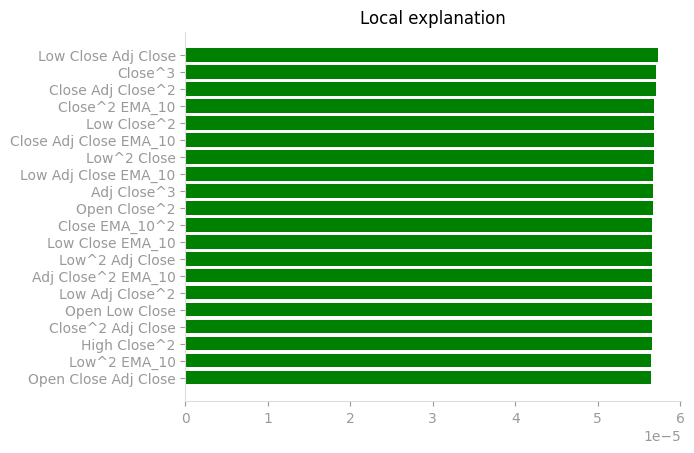

In [ ]:

# assuming 'ensemble_model' is your trained regression ensemble model
def predict(X):
    preds = ensemble_model.predict(X)
    return preds


explainer = lime.lime_tabular.LimeTabularExplainer(training_data=X_train_poly,
                                                   mode='regression',
                                                   feature_names=feature_names,
                                                   class_names=None,
                                                   discretize_continuous=False)

# explain a single instance using the LIME explainer
exp = explainer.explain_instance(
    X_test_poly[1], predict, num_features=20)

# print the LIME explanation
print(exp.as_list())

# plot the LIME explanation
exp.show_in_notebook()

# style the LIME explanation using to_pyplot()
fig = exp.as_pyplot_figure()
axes = fig.get_axes()[0]  # get the axes object

# adjust the spines
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.spines['bottom'].set_color('#DDDDDD')
axes.spines['left'].set_color('#DDDDDD')
axes.tick_params(axis='x', colors='#999999')
axes.tick_params(axis='y', colors='#999999')
axes.yaxis.label.set_color('#999999')
axes.xaxis.label.set_color('#999999')